In [1]:
from utils import *
from DataGenerator import *
from Models_normal import *
import torch.optim as optim
from Analysis import fixed_model_batch_analysis
from DataLoader import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.linear_model import RANSACRegressor


In [2]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 32, 16, 8, 3], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)

state_dict = torch.load('../running_scripts/sept_result_mnist/mnist_training/try_num0/epoch_60/model.pth', weights_only=False)
model.load_state_dict(state_dict)

model.eval()


# load the data
_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [3]:
def plot_data_projection(ax, counter, anim_pieces, type_analysis='pca', dim=2, title='layers: ', labels_all: list = []):

    labels = labels_all[0]
    
    # Find unique labels and the number of unique classes
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    
    # Dynamically select an appropriate colormap
    if num_classes <= 10:
        cmap = plt.get_cmap('tab10')  # type: ignore # Use tab10 for 10 or fewer classes
    elif num_classes <= 20:
        cmap = plt.get_cmap('tab20')  # type: ignore # Use tab20 for 11-20 classes
    else:
        cmap = plt.cm.get_cmap('viridis', num_classes)  # type: ignore # Use continuous colormap for more than 20 classes
    
    # Map each unique label to a specific color in the colormap
    color_map = {label: cmap(i / num_classes) for i, label in enumerate(unique_labels)}
    
    # Assign colors to each data point based on its label
    colors = [color_map[label] for label in labels]
    
    # Select appropriate scatter plot based on dimension
    if dim == 2:
        ax.scatter(anim_pieces[counter][0], anim_pieces[counter][1], c=colors, s=10)
    elif dim == 3:
        ax.scatter(anim_pieces[counter][0], anim_pieces[counter][1], anim_pieces[counter][2], c=colors, s=10)
    
    # If labels are provided, add a legend
    if labels is not None:
        # Create a list of legend handles
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label],  # type: ignore
                              markersize=8, label=f'Class {label}') for label in unique_labels]
        
        # Add the legend to the axis
        ax.legend(handles=handles, title="Classes", loc="best")
    
    ax.grid(True)

    if type_analysis == 'pca':
        ax.set_xlabel('First Principal Component')
        ax.set_ylabel('Second Principal Component')
        if dim == 2:
            # ax.quiver([0, 0], eigenvectors[0][:, -1][0], eigenvectors[0][:, -1][1])
            # ax.quiver([0, 0], eigenvectors[0][:, -2][0], eigenvectors[0][:, -2][1])
            ax.set_title('Data in First Two Principal Components')
        if dim == 3:
            ax.set_zlabel('Third Principal Component')
            ax.set_title('Data in First Three Principal Components')
    elif type_analysis == 'random':
        ax.set_xlabel('First Random Diemnsion')
        ax.set_ylabel('Second Random Dimension')
        ax.set_title('Data in Two Random Dimension')
        if dim == 2:
            ax.set_title('Data in Two Random Dimension')
        if dim == 3:
            ax.set_zlabel('Third Random Dimension')
            ax.set_title('Data in Three Random Dimension')
    if type(title) is list:
        ax.set_title(title[counter])
    else:
        ax.set_title(f'{title} {counter + 1}')

    return colors

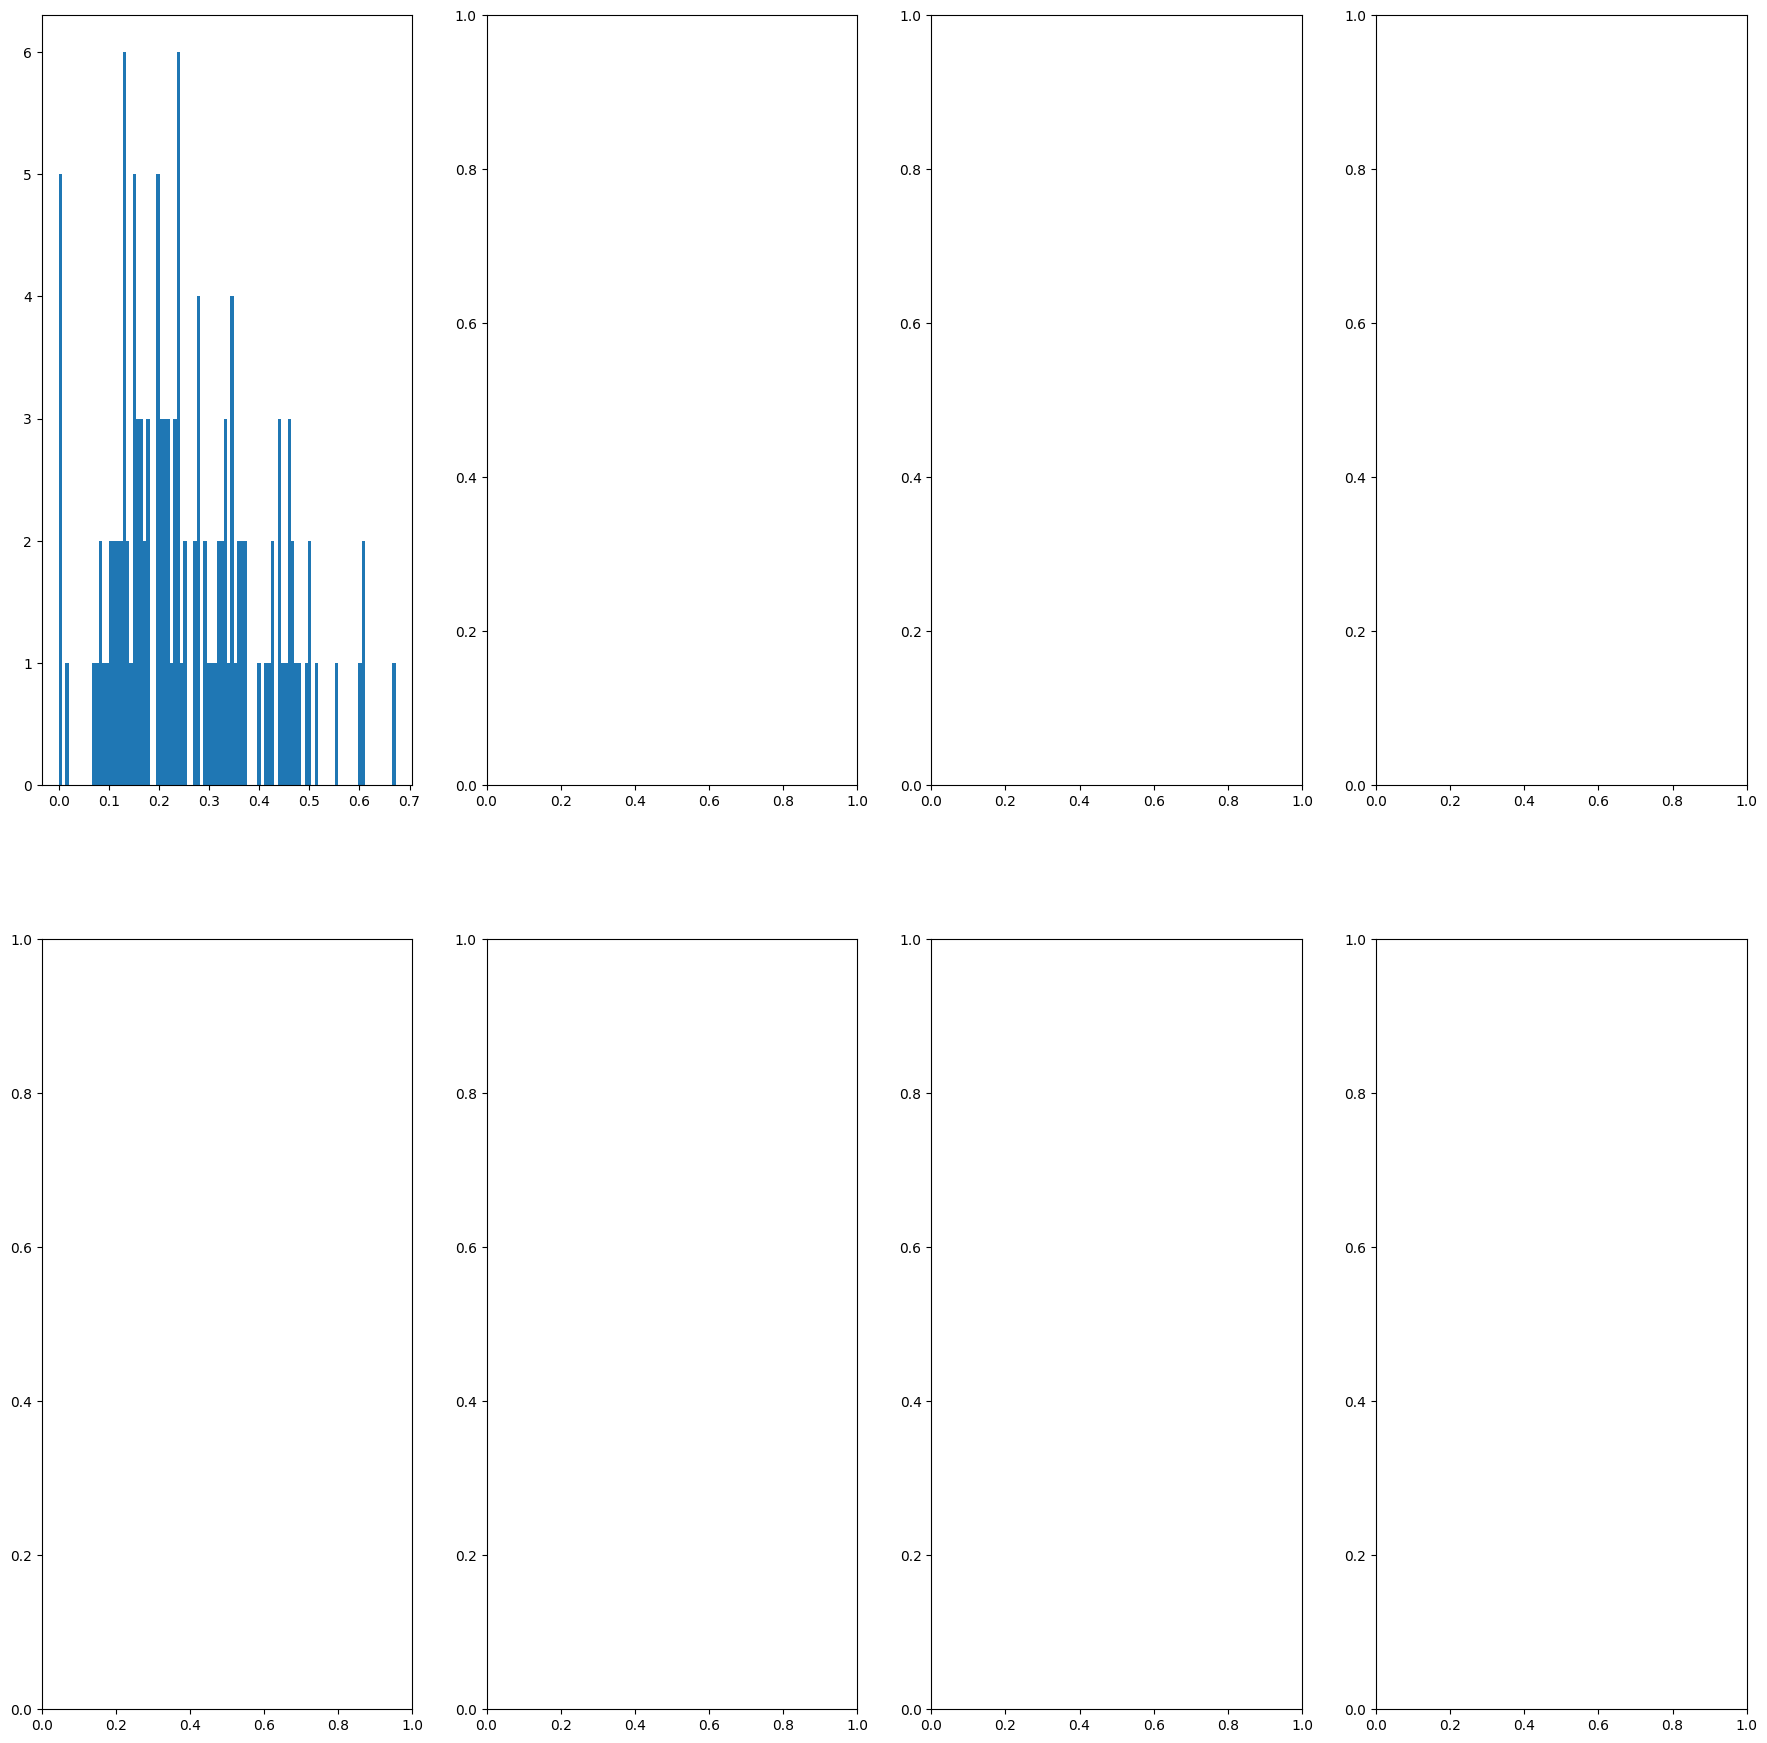

---


In [4]:
anal_path = '../spike_analysis/spike_resume/'
if not os.path.isdir(anal_path):
    os.makedirs(anal_path)
results_dict = fixed_model_batch_analysis(model, train_samples, train_labels, device, '{}_{}'.format(anal_path, 'train_'), 'analyze')
plt.close()
print("---")

In [5]:
def iterative_line_fitting(data, max_clusters=5, coverage_threshold=0.95, residual_threshold=3, max_steps=50):
    remaining_data = data.copy()
    all_clusters = []
    all_indices = []
    line_params = []
    total_points = len(data)
    total_covered = 0
    step_count = 0

    # Keep track of original indices
    remaining_indices = np.arange(total_points)

    while total_covered / total_points < coverage_threshold:
        step_count += 1
        if step_count > max_steps:
            print(f"Stopping after reaching max steps: {max_steps}")
            break

        # Fit line using RANSAC
        model = RANSACRegressor(residual_threshold=residual_threshold)
        model.fit(remaining_data[:, 0].reshape(-1, 1), remaining_data[:, 1])
        
        # Get slope of the fitted line
        slope = model.estimator_.coef_[0]
        line_params.append(slope)
        
        # Predict to get the line fit
        line_x = remaining_data[:, 0]
        line_y = model.predict(line_x.reshape(-1, 1))

        # Calculate residuals and determine inliers
        residuals = np.abs(remaining_data[:, 1] - line_y)
        inlier_mask = residuals < residual_threshold
        inliers = remaining_data[inlier_mask]

        # Store inliers and their original indices
        inlier_indices = remaining_indices[inlier_mask]

        all_clusters.append(inliers)
        all_indices.append(inlier_indices)

        # Update remaining data and indices
        remaining_data = remaining_data[~inlier_mask]
        remaining_indices = remaining_indices[~inlier_mask]

        # Update total covered points
        total_covered += len(inliers)

    # Function to calculate angle between two slopes
    def calculate_angle(slope1, slope2):
        tan_theta = abs((slope2 - slope1) / (1 + slope1 * slope2))
        return np.arctan(tan_theta) * 180 / np.pi

    # Merge clusters if there are more than the specified max_clusters
    if len(all_clusters) > max_clusters:
        # Keep merging until the number of clusters is equal to max_clusters
        while len(all_clusters) > max_clusters:
            min_angle = float('inf')
            merge_idx1, merge_idx2 = -1, -1

            # Find the pair of clusters with the smallest angle between their lines
            for (i, j) in itertools.combinations(range(len(line_params)), 2):
                angle = calculate_angle(line_params[i], line_params[j])
                if angle < min_angle:
                    # Check if merging these two lines would lead to an angle greater than 90 degrees within the cluster
                    new_slope_list = [line_params[k] for k in range(len(line_params)) if k not in (i, j)] + [(line_params[i] + line_params[j]) / 2]
                    valid_merge = True
                    for slope1, slope2 in itertools.combinations(new_slope_list, 2):
                        if calculate_angle(slope1, slope2) > 90:
                            valid_merge = False
                            break

                    # If valid merge, update the candidate for merging
                    if valid_merge:
                        min_angle = angle
                        merge_idx1, merge_idx2 = i, j

            # Merge the clusters with the smallest angle if they are valid
            if merge_idx1 != -1 and merge_idx2 != -1:
                # Merge the clusters and line parameters
                all_clusters[merge_idx1] = np.vstack((all_clusters[merge_idx1], all_clusters[merge_idx2]))
                all_indices[merge_idx1] = np.hstack((all_indices[merge_idx1], all_indices[merge_idx2]))
                merged_slope = (line_params[merge_idx1] + line_params[merge_idx2]) / 2
                line_params[merge_idx1] = merged_slope

                # Remove the merged cluster
                del all_clusters[merge_idx2]
                del all_indices[merge_idx2]
                del line_params[merge_idx2]

    return all_clusters, all_indices


In [15]:
num_spikes_per_class = 3
num_samples_per_spike = 3
mnist_labels = train_labels.detach().cpu().numpy()
mnist_data = train_samples.detach().cpu().numpy().reshape(train_samples.shape[0], 28 * 28)
# Number of classes
num_classes = len(np.unique(mnist_labels))
print(num_classes)

for idx_layer in tqdm(range(len(results_dict['random_2']))):

    mnist_pca_2d = np.array(results_dict['random_2'][idx_layer]).transpose()

    # Create the overall figure
    fig = plt.figure(figsize=(36, 50))
    outer_grid = fig.add_gridspec(num_classes + 1, 2, width_ratios=[1.2, 1.8], height_ratios=[1] + [0.6] * num_classes)


    # Original PCA plot for the entire dataset
    ax_pca = fig.add_subplot(outer_grid[0, 0])
    ax_pca.set_title('2D PCA of Original MNIST Dataset')

    colors = np.array(plot_data_projection(ax_pca, idx_layer, results_dict['pca_2'], labels_all=results_dict['labels']))


    # Process each class for clustering and sample visualization
    for class_idx in range(num_classes):
        # Extract the data points belonging to the current class
        class_data_indices = np.where(mnist_labels == class_idx)[0]
        class_data = mnist_pca_2d[class_data_indices]

        # Apply iterative line fitting clustering to the class data
        clusters, cluster_indices = iterative_line_fitting(class_data)

        # Plot the clustering for the current class
        class_cluster_ax = fig.add_subplot(outer_grid[class_idx + 1, 0])
        class_cluster_ax.set_title(f'Clustering of Class {class_idx} (PCA Reduced)')
        for cluster_idx, cluster in enumerate(clusters):
            cluster_color = colors[cluster_idx % len(colors)]
            class_cluster_ax.scatter(cluster[:, 0], cluster[:, 1], label=f'Spike {cluster_idx + 1}', color=cluster_color)
        class_cluster_ax.set_xlabel('First Principal Component')
        class_cluster_ax.set_ylabel('Second Principal Component')
        class_cluster_ax.legend(title='Clusters')

        # Create a grid to hold the sample images for each cluster of the current class
        # sample_grid = fig.add_subplot(outer_grid[class_idx + 1, 1])
        cluster_gridspec = gridspec.GridSpecFromSubplotSpec(1, len(clusters), subplot_spec=outer_grid[class_idx + 1, 1], wspace=0.3)

        for cluster_idx, cluster in enumerate(clusters):
            # Create a subplot for each cluster to contain its samples
            cluster_ax = fig.add_subplot(cluster_gridspec[0, cluster_idx])
            cluster_ax.axis('off')
            cluster_ax.set_title(f'Cluster {cluster_idx + 1}', fontsize=10)

            # Plot 15 random samples for the current cluster in a 3x5 grid
            num_samples = min(60, len(cluster_indices[cluster_idx]))
            rows, cols = 6, 10
            grid = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=cluster_gridspec[0, cluster_idx], wspace=0.1, hspace=0.1)

            for sample_idx in range(num_samples):
                random_idx = random.choice(cluster_indices[cluster_idx])
                sample_image = mnist_data[class_data_indices[random_idx]].reshape(28, 28)
                
                # Determine position within the 3x5 grid
                row, col = divmod(sample_idx, cols)
                sub_ax = fig.add_subplot(grid[row, col])
                sub_ax.imshow(sample_image, cmap='gray')
                sub_ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Add spacing to avoid overlap
    fig.savefig(f"{anal_path}spike_plot{idx_layer}.png")
    plt.close()

10


 42%|████▏     | 5/12 [03:45<05:53, 50.55s/it]

Stopping after reaching max steps: 50
Stopping after reaching max steps: 50


 50%|█████     | 6/12 [04:43<05:17, 52.95s/it]

Stopping after reaching max steps: 50


100%|██████████| 12/12 [09:03<00:00, 45.30s/it]


In [42]:
fig.savefig("sample.png")

In [25]:
pca_2 = np.array(results_dict['pca_2'][10])
X = pca_2.transpose()
y = np.array(results_dict['labels'][0])

class_index = 6
filtered_indices = np.where(y == class_index)[0]  # Get the indices of the original dataset that belong to class_index
X_filtered = X[filtered_indices]  # Filtered data for class_index


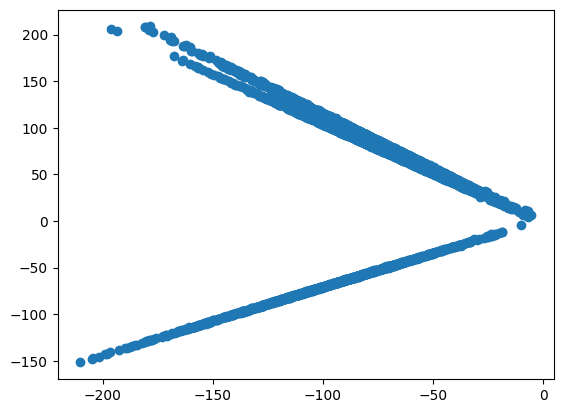

In [26]:
plt.scatter(X_filtered[:, 0], X_filtered[:, 1])

In [77]:
def separate_spikes_(data, eps=3, min_samples=10):
    # Apply DBSCAN to find clusters (spikes)
    clustering = BisectingKMeans(n_clusters=4).fit(data)

    # Get the cluster labels
    labels = clustering.labels_

    # Separate the data into different spikes based on labels
    unique_labels = set(labels)
    spikes = [data[labels == label] for label in unique_labels if label != -1]  # -1 is for noise
    spike_indices = [np.where(labels == label)[0] for label in unique_labels if label != -1]  # Indices of points in each spike

    return spikes, spike_indices


def separate_spikes(data, eps=3, min_samples=10):
    # Apply DBSCAN to find clusters (spikes)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data)

    # Get the cluster labels
    labels = clustering.labels_

    # Separate the data into different spikes based on labels
    unique_labels = set(labels)
    spikes = [data[labels == label] for label in unique_labels if label != -1]  # -1 is for noise
    spike_indices = [np.where(labels == label)[0] for label in unique_labels if label != -1]  # Indices of points in each spike

    return spikes, spike_indices

In [80]:
def iterative_line_fitting(data, coverage_threshold=0.95, residual_threshold=3):
    remaining_data = data.copy()
    all_clusters = []
    all_indices = []
    total_points = len(data)
    total_covered = 0

    # Keep track of original indices
    remaining_indices = np.arange(total_points)

    while total_covered / total_points < coverage_threshold:
        # Fit line using RANSAC
        model = RANSACRegressor(residual_threshold=residual_threshold)
        model.fit(remaining_data[:, 0].reshape(-1, 1), remaining_data[:, 1])
        
        # Predict to get the line fit
        line_x = remaining_data[:, 0]
        line_y = model.predict(line_x.reshape(-1, 1))
        
        # Calculate residuals and determine inliers
        residuals = np.abs(remaining_data[:, 1] - line_y)
        inlier_mask = residuals < residual_threshold
        inliers = remaining_data[inlier_mask]
        
        # Store inliers and their original indices
        inlier_indices = remaining_indices[inlier_mask]
        
        all_clusters.append(inliers)
        all_indices.append(inlier_indices)
        
        # Update remaining data and indices
        remaining_data = remaining_data[~inlier_mask]
        remaining_indices = remaining_indices[~inlier_mask]
        
        # Update total covered points
        total_covered += len(inliers)

    return all_clusters, all_indices

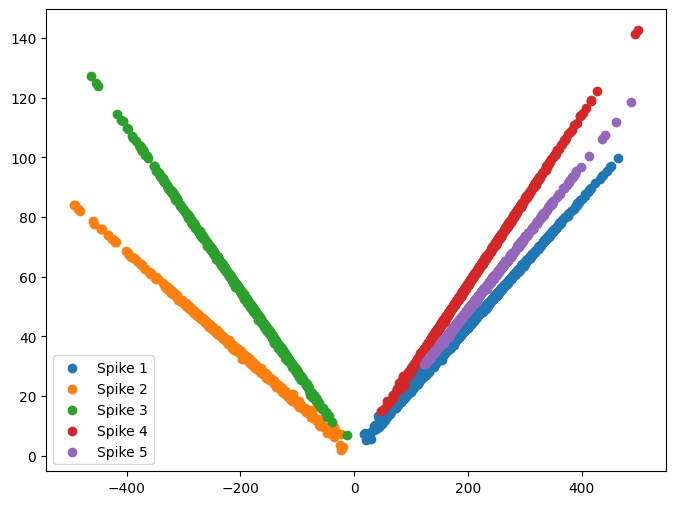

In [81]:
# Separate spikes
spikes, spike_indices_in_filtered = iterative_line_fitting(X_filtered)

spikes_original_indices = [filtered_indices[indices] for indices in spike_indices_in_filtered]


# Plot the results
plt.figure(figsize=(8, 6))
for i, spike in enumerate(spikes):
    plt.scatter(spike[:, 0], spike[:, 1], label=f'Spike {i+1}')
plt.legend()
plt.show()

In [186]:
mnist_data = train_samples.detach().cpu().numpy().reshape(train_samples.shape[0], 28, 28)
assert train_labels[spikes_original_indices[0][50]] == class_index

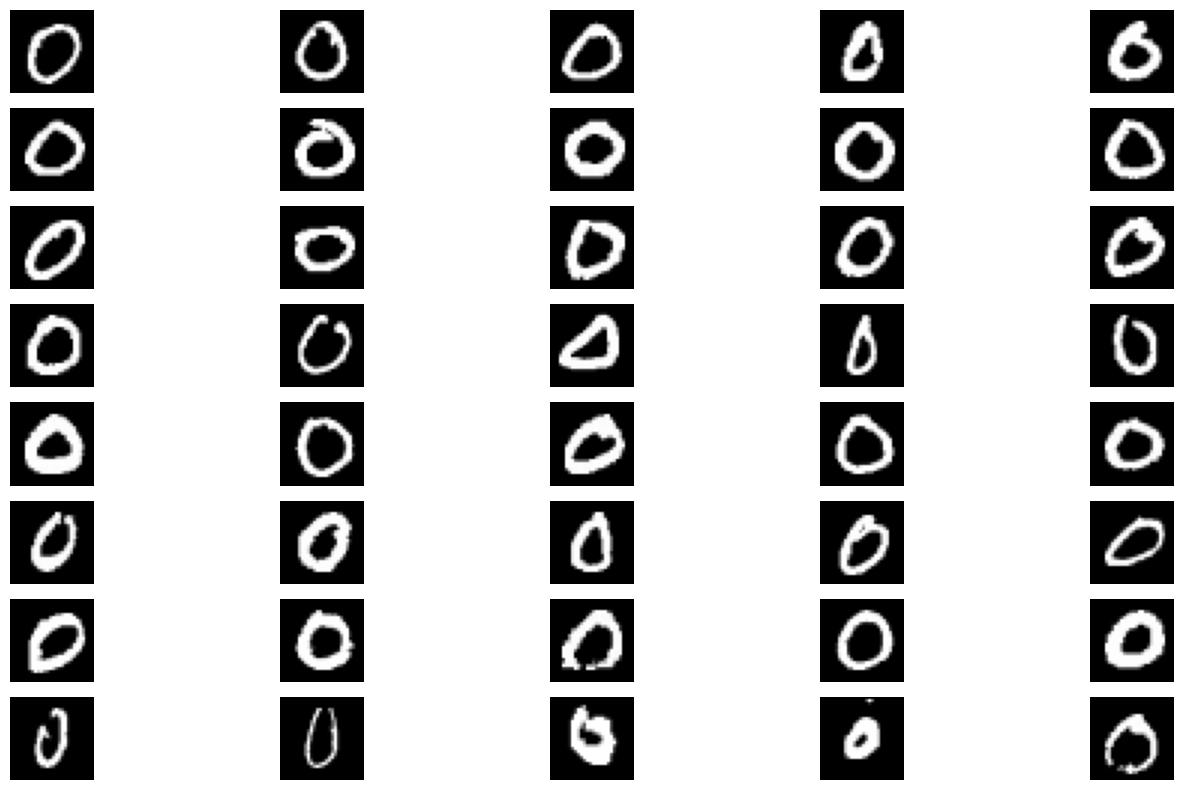

In [187]:
# Number of spikes to consider
num_spikes = len(spikes_original_indices)
num_samples_per_spike = 5

# Create the plot
fig, axes = plt.subplots(num_spikes, num_samples_per_spike, figsize=(15, 8))

for i, spike_indices in enumerate(spikes_original_indices):
    
    # Pick 5 random samples from each spike
    random_indices = random.sample(list(spike_indices), num_samples_per_spike)

    # Plot each sample in the corresponding subplot
    for j, idx in enumerate(random_indices):
        ax = axes[i, j]
        ax.imshow(mnist_data[idx], cmap='gray')
        ax.axis('off')

        if j == 0:
            ax.set_ylabel(f'Spike {i+1}', fontsize=12)

plt.tight_layout()
plt.show()

In [195]:
results_dict.keys()

dict_keys(['activations', 'non_zero_activations_layer_wise', 'cell_dimensions', 'batch_cell_dimensions', 'nonzero_eigenvalues_count', 'eigenvalues', 'stable_rank', 'simple_spherical_mean_width', 'spherical_mean_width_v2', 'norms', 'eigenvectors', 'pca_2', 'pca_3', 'random_2', 'random_3', 'covar_matrix', 'this_batch_size', 'labels', 'display_matrix'])

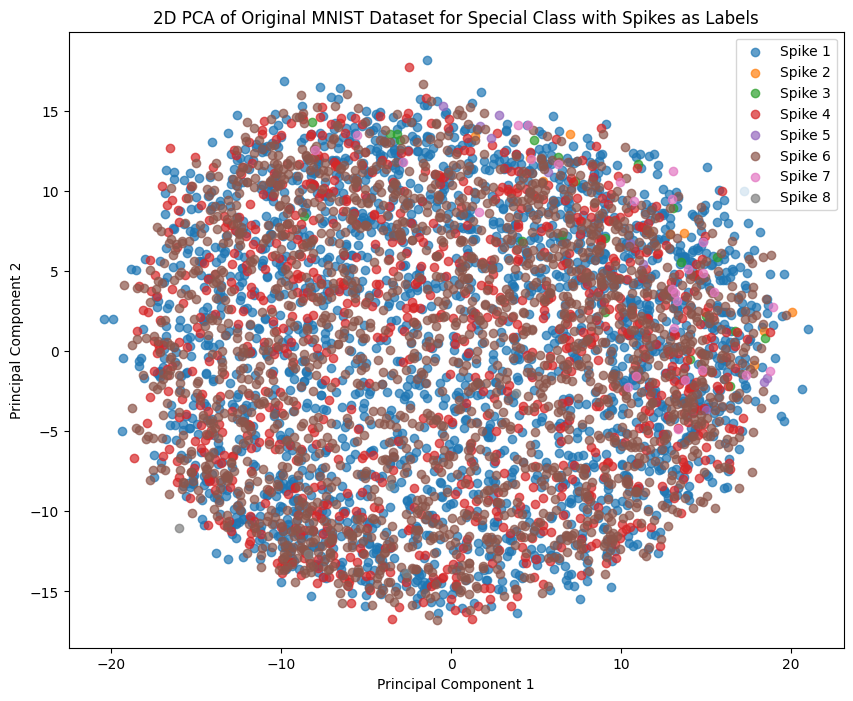

In [190]:
# Filter data by class_index
class_data_indices = np.where(train_labels == class_index)[0]
mnist_class_data = train_samples[class_data_indices]

# Assign spike labels from the previous clustering
spike_labels = np.zeros(len(class_data_indices), dtype=int)

# For each spike, assign the corresponding label
for spike_idx, spike_indices in enumerate(spikes_original_indices):
    # Find the corresponding indices in the original MNIST class data
    filtered_indices_in_class_data = np.where(np.isin(class_data_indices, spike_indices))[0]
    spike_labels[filtered_indices_in_class_data] = spike_idx

# Apply PCA for 2D reduction on the entire special class dataset
pca = PCA(n_components=2)
mnist_class_pca_2d = pca.fit_transform(mnist_class_data)

# Plot the 2D PCA results
plt.figure(figsize=(10, 8))

# Plot each spike in different colors
for spike_idx in range(len(spikes_original_indices)):
    spike_data = mnist_class_pca_2d[spike_labels == spike_idx]
    plt.scatter(spike_data[:, 0], spike_data[:, 1], label=f'Spike {spike_idx + 1}', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Original MNIST Dataset for Special Class with Spikes as Labels')
plt.legend()
plt.show()